In [1]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu
@modified by : Jingchao Song

Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3
    
dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
See Github: https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py
See Youtube: https://youtu.be/tepxdcepTbY

"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime


import yfinance as yf

In [22]:
BTC_data = yf.Ticker('BTC-USD').history('Max')
df = BTC_data[['Open','High','Low','Close']]

df.shape

(2608, 4)

In [23]:
df.reset_index(inplace = True)

In [24]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

2593   2021-10-27
2594   2021-10-28
2595   2021-10-29
2596   2021-10-30
2597   2021-10-31
2598   2021-11-01
2599   2021-11-02
2600   2021-11-03
2601   2021-11-04
2602   2021-11-05
2603   2021-11-06
2604   2021-11-07
2605   2021-11-08
2606   2021-11-09
2607   2021-11-10
Name: Date, dtype: datetime64[ns]


In [25]:
#Variables for training
cols = list(df)[1:5]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

['Open', 'High', 'Low', 'Close']


In [26]:
#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1  #1 day    # Number of days we want to look into the future based on the past days.
n_past = 7  #14 days  # Number of past days we want to use to predict the future.

In [27]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (2601, 7, 4).
trainY shape == (2601, 1).


In [39]:
trainX.dtype

dtype('float64')

In [28]:
#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 7, 32)             4736      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 7,889
Trainable params: 7,889
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.1734
Epoch 2/100
130/130 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.1961
Epoch 3/100
130/130 [==============================] - 0s 2ms/step - loss: 0.0029 - val_loss: 0.2337
Epoch 4/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.4075
Epoch 5/100
130/130 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.2310
Epoch 6/100
130/130 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.2834
Epoch 7/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.2852
Epoch 8/100
130/130 [==============================] - 0s 2ms/step - loss: 0.0028 - val_loss: 0.1694
Epoch 9/100
130/130 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0877
Epoch 10/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0029 - val_lo

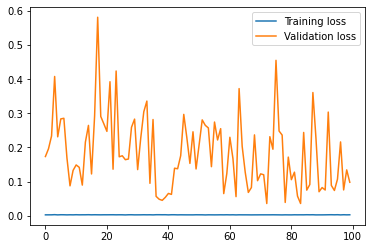

In [35]:
# fit the model
history = model.fit(trainX, trainY, epochs=100, batch_size=16, validation_split=0.2, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [36]:
#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  

# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay
# us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 15
n_days_for_prediction=30 #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq='1d').tolist()
print(predict_period_dates)


[Timestamp('2021-10-27 00:00:00', freq='D'), Timestamp('2021-10-28 00:00:00', freq='D'), Timestamp('2021-10-29 00:00:00', freq='D'), Timestamp('2021-10-30 00:00:00', freq='D'), Timestamp('2021-10-31 00:00:00', freq='D'), Timestamp('2021-11-01 00:00:00', freq='D'), Timestamp('2021-11-02 00:00:00', freq='D'), Timestamp('2021-11-03 00:00:00', freq='D'), Timestamp('2021-11-04 00:00:00', freq='D'), Timestamp('2021-11-05 00:00:00', freq='D'), Timestamp('2021-11-06 00:00:00', freq='D'), Timestamp('2021-11-07 00:00:00', freq='D'), Timestamp('2021-11-08 00:00:00', freq='D'), Timestamp('2021-11-09 00:00:00', freq='D'), Timestamp('2021-11-10 00:00:00', freq='D'), Timestamp('2021-11-11 00:00:00', freq='D'), Timestamp('2021-11-12 00:00:00', freq='D'), Timestamp('2021-11-13 00:00:00', freq='D'), Timestamp('2021-11-14 00:00:00', freq='D'), Timestamp('2021-11-15 00:00:00', freq='D'), Timestamp('2021-11-16 00:00:00', freq='D'), Timestamp('2021-11-17 00:00:00', freq='D'), Timestamp('2021-11-18 00:00:00'

In [37]:
#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

C:\Users\jingc\AppData\Local\Temp/ipykernel_14184/2190141466.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword wil

<AxesSubplot:xlabel='Date', ylabel='Open'>

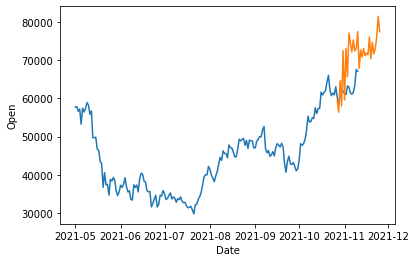

In [38]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2021-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])